# Orignalny kod

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

In [2]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [3]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [4]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [5]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        
        for epoch in range(num_epochs):
            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    print(message)    
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
        return history
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

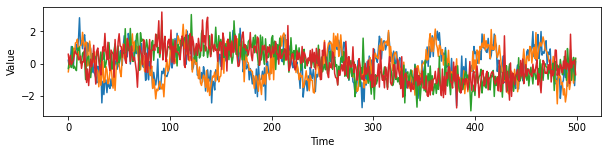

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [7]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [8]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [9]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 4.084, mse= 3.736, kld= 3.477
	val_loss= 4.590, val_mse= 4.325, val_kld= 2.652
Epoch= 2/200, loss= 4.058, mse= 3.796, kld= 2.614
	val_loss= 4.575, val_mse= 4.367, val_kld= 2.083
Epoch= 3/200, loss= 3.820, mse= 3.608, kld= 2.122
	val_loss= 3.912, val_mse= 3.744, val_kld= 1.682
Epoch= 4/200, loss= 3.814, mse= 3.641, kld= 1.726
	val_loss= 3.966, val_mse= 3.818, val_kld= 1.470
Epoch= 5/200, loss= 3.804, mse= 3.659, kld= 1.449
	val_loss= 4.335, val_mse= 4.211, val_kld= 1.247
Epoch= 6/200, loss= 3.963, mse= 3.844, kld= 1.190
	val_loss= 3.631, val_mse= 3.514, val_kld= 1.169
Epoch= 7/200, loss= 3.590, mse= 3.489, kld= 1.014
	val_loss= 3.990, val_mse= 3.879, val_kld= 1.111
Epoch= 8/200, loss= 3.828, mse= 3.736, kld= 0.929
	val_loss= 3.757, val_mse= 3.647, val_kld= 1.095
Epoch= 9/200, loss= 3.525, mse= 3.438, kld= 0.866
	val_loss= 3.588, val_mse= 3.472, val_kld= 1.167
Epoch= 10/200, loss= 3.519, mse= 3.433, kld= 0.867
	val_loss= 3.939, val_mse= 3.815, val_kld= 1.234
Epoch= 11

Epoch= 84/200, loss= 1.725, mse= 1.619, kld= 1.064
	val_loss= 1.835, val_mse= 1.716, val_kld= 1.190
Epoch= 85/200, loss= 1.828, mse= 1.726, kld= 1.015
	val_loss= 1.750, val_mse= 1.657, val_kld= 0.935
Epoch= 86/200, loss= 1.776, mse= 1.678, kld= 0.979
	val_loss= 1.777, val_mse= 1.683, val_kld= 0.939
Epoch= 87/200, loss= 1.788, mse= 1.691, kld= 0.969
	val_loss= 1.559, val_mse= 1.443, val_kld= 1.162
Epoch= 88/200, loss= 1.678, mse= 1.580, kld= 0.981
	val_loss= 1.765, val_mse= 1.665, val_kld= 0.992
Epoch= 89/200, loss= 1.684, mse= 1.589, kld= 0.951
	val_loss= 1.580, val_mse= 1.478, val_kld= 1.024
Epoch= 90/200, loss= 1.708, mse= 1.610, kld= 0.986
	val_loss= 1.601, val_mse= 1.494, val_kld= 1.073
Epoch= 91/200, loss= 1.632, mse= 1.538, kld= 0.943
	val_loss= 1.544, val_mse= 1.434, val_kld= 1.096
Epoch= 92/200, loss= 1.718, mse= 1.629, kld= 0.887
	val_loss= 1.371, val_mse= 1.269, val_kld= 1.020
Epoch= 93/200, loss= 1.613, mse= 1.525, kld= 0.884
	val_loss= 1.673, val_mse= 1.591, val_kld= 0.819


Epoch= 166/200, loss= 1.241, mse= 1.157, kld= 0.839
	val_loss= 1.142, val_mse= 1.052, val_kld= 0.907
Epoch= 167/200, loss= 1.205, mse= 1.125, kld= 0.793
	val_loss= 1.074, val_mse= 0.991, val_kld= 0.835
Epoch= 168/200, loss= 1.268, mse= 1.187, kld= 0.809
	val_loss= 1.184, val_mse= 1.084, val_kld= 1.003
Epoch= 169/200, loss= 1.229, mse= 1.147, kld= 0.817
	val_loss= 1.245, val_mse= 1.151, val_kld= 0.938
Epoch= 170/200, loss= 1.133, mse= 1.048, kld= 0.845
	val_loss= 1.231, val_mse= 1.159, val_kld= 0.725
Epoch= 171/200, loss= 1.136, mse= 1.056, kld= 0.805
	val_loss= 1.186, val_mse= 1.086, val_kld= 1.002
Epoch= 172/200, loss= 1.208, mse= 1.125, kld= 0.827
	val_loss= 1.020, val_mse= 0.947, val_kld= 0.732
Epoch= 173/200, loss= 1.153, mse= 1.076, kld= 0.765
	val_loss= 1.119, val_mse= 1.039, val_kld= 0.801
Epoch= 174/200, loss= 1.219, mse= 1.129, kld= 0.897
	val_loss= 1.187, val_mse= 1.104, val_kld= 0.829
Epoch= 175/200, loss= 1.160, mse= 1.070, kld= 0.898
	val_loss= 1.234, val_mse= 1.158, val_k

<AxesSubplot:xlabel='Epoch'>

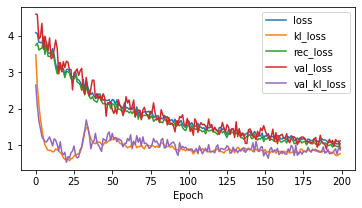

In [10]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

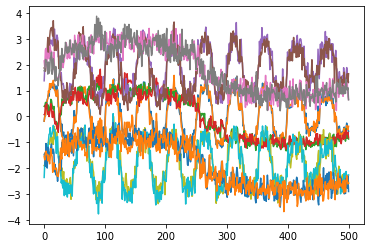

In [11]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

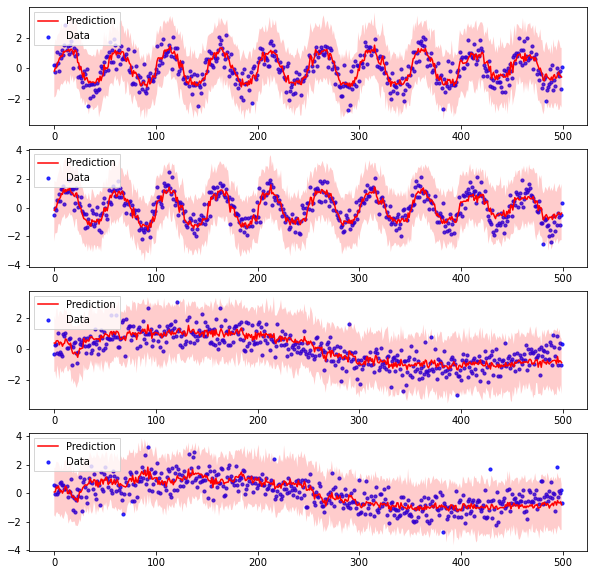

In [12]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

# Moja praca

## Wczytanie danych

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch

In [15]:


#FIRST on 10 000 workouts - train 9000, test 1000
data_endo = []
i = 0
#with gzip.open('endomondoHR.json.gz') as f:

with open('endomondoHR_proper.json') as f:
    for l in f:
        i += 1
        #print(i)
        data_endo.append(eval(l))
        if i == 10000:
            break
        #print(data[0])

## Wstępne wykresy

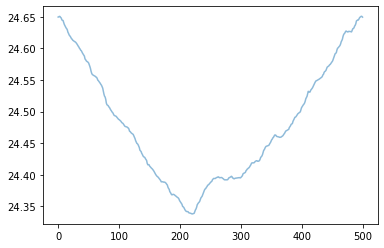

In [16]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

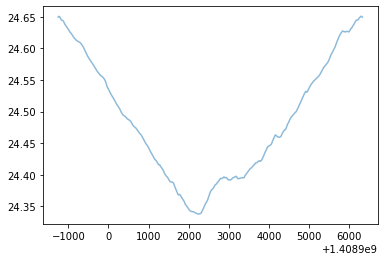

In [17]:

# Plot timestamp x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


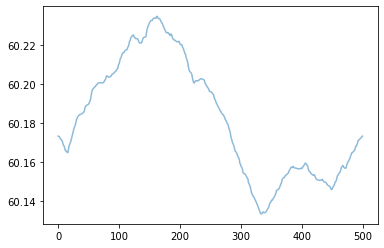

In [18]:

# Plot ithmeasurement x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

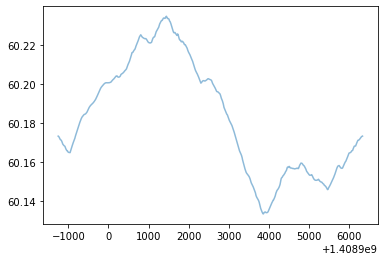

In [19]:

# Plot timestamp x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


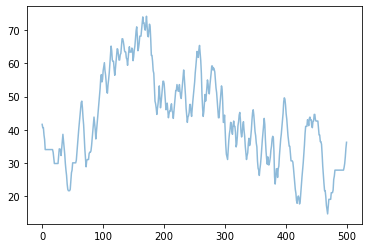

In [20]:

# Plot ithmeasurement x altitude

#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

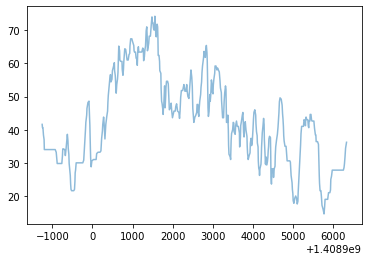

In [21]:

# Plot timestamp x altitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

In [22]:
####OK wykresy sie zgadzaja

In [23]:
###TERAZ TRENUJEMY DLA 1 WORKOUTU LONGITUDE,TRAIN TO PIERWSZE 450 A VAL TO KOLEJNE 50

In [24]:
#### ITHMEASUREMENT vs LONGITUDE

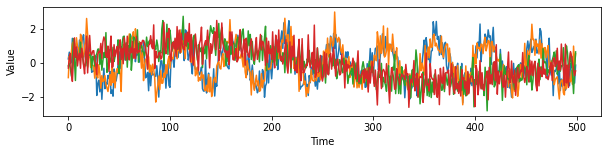

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)
#print(data.shape[1])

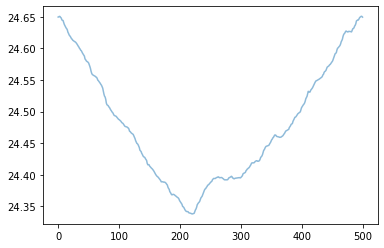

In [27]:

# Plot ithmeasurement x longitude



#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

## Trenowane dla 1 treningo po longitude

In [28]:
#x = torch.FloatTensor(data).reshape(1, *data.shape)
#x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

y_data = torch.FloatTensor(y).reshape(1, 500, 1)
#print(y_data)
y_train = torch.FloatTensor(y[:450]).reshape(1, 450, 1)
#print(y_train)
y_val = torch.FloatTensor(y[450:500]).reshape(1, 50, 1)
#print(y_val)


In [29]:
dkf = DKF(input_dim=1, z_dim=5, rnn_dim=5, trans_dim=5, emission_dim=5)

In [30]:
history = dkf.fit(y_train, y_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 602.290, mse= 601.823, kld= 4.672
	val_loss= 613.279, val_mse= 612.777, val_kld= 5.014
Epoch= 2/200, loss= 602.305, mse= 601.826, kld= 4.780
	val_loss= 593.956, val_mse= 593.469, val_kld= 4.863
Epoch= 3/200, loss= 597.139, mse= 596.652, kld= 4.876
	val_loss= 599.939, val_mse= 599.388, val_kld= 5.511
Epoch= 4/200, loss= 601.880, mse= 601.340, kld= 5.406
	val_loss= 597.171, val_mse= 596.568, val_kld= 6.030
Epoch= 5/200, loss= 591.181, mse= 590.550, kld= 6.318
	val_loss= 584.929, val_mse= 584.175, val_kld= 7.546
Epoch= 6/200, loss= 584.765, mse= 584.036, kld= 7.291
	val_loss= 597.986, val_mse= 597.130, val_kld= 8.559
Epoch= 7/200, loss= 585.687, mse= 584.818, kld= 8.692
	val_loss= 593.301, val_mse= 592.258, val_kld= 10.428
Epoch= 8/200, loss= 573.687, mse= 572.631, kld= 10.555
	val_loss= 557.416, val_mse= 556.030, val_kld= 13.855
Epoch= 9/200, loss= 569.449, mse= 568.163, kld= 12.863
	val_loss= 565.704, val_mse= 564.106, val_kld= 15.980
Epoch= 10/200, loss= 569.153, ms

Epoch= 80/200, loss= 2.230, mse= 1.911, kld= 3.184
	val_loss= 2.303, val_mse= 1.885, val_kld= 4.181
Epoch= 81/200, loss= 2.368, mse= 2.054, kld= 3.144
	val_loss= 2.432, val_mse= 2.006, val_kld= 4.256
Epoch= 82/200, loss= 2.387, mse= 2.076, kld= 3.108
	val_loss= 1.986, val_mse= 1.566, val_kld= 4.205
Epoch= 83/200, loss= 2.464, mse= 2.156, kld= 3.078
	val_loss= 2.844, val_mse= 2.428, val_kld= 4.164
Epoch= 84/200, loss= 2.277, mse= 1.971, kld= 3.055
	val_loss= 1.925, val_mse= 1.507, val_kld= 4.186
Epoch= 85/200, loss= 2.340, mse= 2.036, kld= 3.049
	val_loss= 2.120, val_mse= 1.704, val_kld= 4.153
Epoch= 86/200, loss= 2.333, mse= 2.030, kld= 3.026
	val_loss= 2.170, val_mse= 1.756, val_kld= 4.142
Epoch= 87/200, loss= 2.017, mse= 1.719, kld= 2.983
	val_loss= 2.505, val_mse= 2.099, val_kld= 4.061
Epoch= 88/200, loss= 2.088, mse= 1.791, kld= 2.975
	val_loss= 2.219, val_mse= 1.809, val_kld= 4.101
Epoch= 89/200, loss= 2.040, mse= 1.747, kld= 2.930
	val_loss= 1.500, val_mse= 1.088, val_kld= 4.112


Epoch= 162/200, loss= 1.233, mse= 1.032, kld= 2.013
	val_loss= 1.474, val_mse= 1.140, val_kld= 3.349
Epoch= 163/200, loss= 1.300, mse= 1.100, kld= 1.999
	val_loss= 1.154, val_mse= 0.819, val_kld= 3.346
Epoch= 164/200, loss= 1.222, mse= 1.020, kld= 2.017
	val_loss= 0.898, val_mse= 0.561, val_kld= 3.369
Epoch= 165/200, loss= 1.312, mse= 1.111, kld= 2.012
	val_loss= 1.626, val_mse= 1.297, val_kld= 3.292
Epoch= 166/200, loss= 1.188, mse= 0.985, kld= 2.036
	val_loss= 1.222, val_mse= 0.879, val_kld= 3.425
Epoch= 167/200, loss= 1.283, mse= 1.080, kld= 2.035
	val_loss= 1.250, val_mse= 0.920, val_kld= 3.304
Epoch= 168/200, loss= 1.223, mse= 1.021, kld= 2.021
	val_loss= 1.270, val_mse= 0.930, val_kld= 3.397
Epoch= 169/200, loss= 1.324, mse= 1.125, kld= 1.989
	val_loss= 1.485, val_mse= 1.145, val_kld= 3.397
Epoch= 170/200, loss= 1.189, mse= 0.989, kld= 1.996
	val_loss= 1.682, val_mse= 1.347, val_kld= 3.353
Epoch= 171/200, loss= 1.185, mse= 0.985, kld= 1.998
	val_loss= 1.502, val_mse= 1.166, val_k

<AxesSubplot:xlabel='Epoch'>

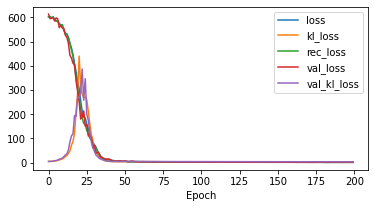

In [31]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

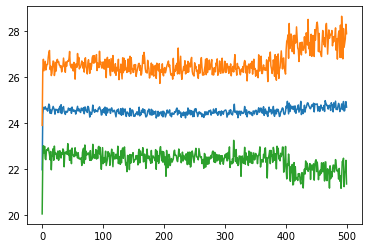

In [32]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(y_data, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

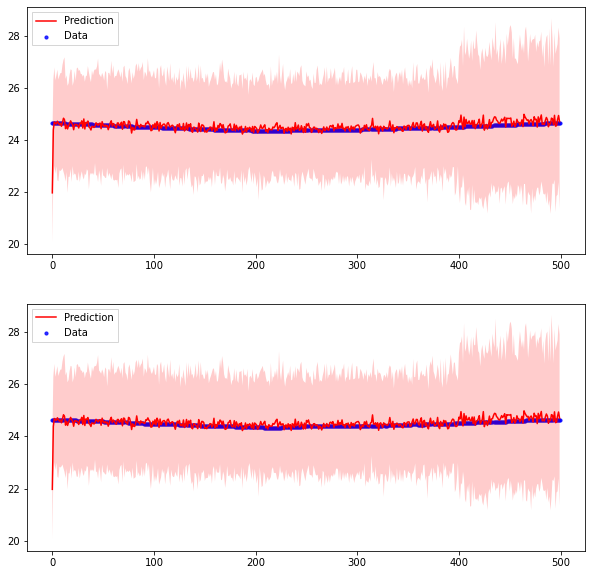

In [33]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(y.shape[0]),
        y[:], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, 0], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, 0], x_975[:, 0],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [34]:
###################################################################################################################

In [35]:
####################################################################################################################

In [36]:
#TUTAJ TRENUJEMY DKF'a dla 1szego WORKOUTU 3 na RAZ LON LAT ALT

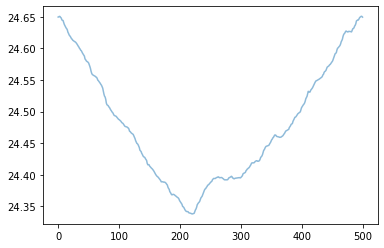

(500, 3)


In [37]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)





first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)

## Trenowane dla pierwszego treningu po longitude, latitude i altitude

In [38]:
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
#print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
#print(x_val)

In [39]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [40]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2135.828, mse= 2124.516, kld= 113.120
	val_loss= 1661.788, val_mse= 1658.344, val_kld= 34.435
Epoch= 2/200, loss= 2083.150, mse= 2076.909, kld= 62.406
	val_loss= 1604.040, val_mse= 1599.497, val_kld= 45.425
Epoch= 3/200, loss= 2002.598, mse= 1993.231, kld= 93.672
	val_loss= 1538.170, val_mse= 1531.325, val_kld= 68.454
Epoch= 4/200, loss= 1855.782, mse= 1804.994, kld= 507.883
	val_loss= 1487.258, val_mse= 1483.345, val_kld= 39.137
Epoch= 5/200, loss= 1789.791, mse= 1783.391, kld= 63.999
	val_loss= 1382.425, val_mse= 1379.060, val_kld= 33.649
Epoch= 6/200, loss= 1628.937, mse= 1624.718, kld= 42.186
	val_loss= 1206.423, val_mse= 1203.521, val_kld= 29.019
Epoch= 7/200, loss= 1368.593, mse= 1363.713, kld= 48.804
	val_loss= 932.989, val_mse= 928.364, val_kld= 46.250
Epoch= 8/200, loss= 984.407, mse= 878.437, kld= 1059.704
	val_loss= 764.817, val_mse= 761.530, val_kld= 32.865
Epoch= 9/200, loss= 785.207, mse= 737.106, kld= 481.017
	val_loss= 625.285, val_mse= 622.041, val_

Epoch= 78/200, loss= 40.049, mse= 39.211, kld= 8.386
	val_loss= 91.984, val_mse= 90.703, val_kld= 12.813
Epoch= 79/200, loss= 40.025, mse= 39.200, kld= 8.246
	val_loss= 90.182, val_mse= 88.884, val_kld= 12.974
Epoch= 80/200, loss= 40.248, mse= 39.422, kld= 8.265
	val_loss= 91.144, val_mse= 89.862, val_kld= 12.825
Epoch= 81/200, loss= 40.120, mse= 39.308, kld= 8.120
	val_loss= 93.185, val_mse= 91.902, val_kld= 12.829
Epoch= 82/200, loss= 40.315, mse= 39.512, kld= 8.037
	val_loss= 87.906, val_mse= 86.631, val_kld= 12.755
Epoch= 83/200, loss= 39.882, mse= 39.089, kld= 7.930
	val_loss= 89.042, val_mse= 87.779, val_kld= 12.635
Epoch= 84/200, loss= 40.017, mse= 39.228, kld= 7.894
	val_loss= 89.639, val_mse= 88.367, val_kld= 12.720
Epoch= 85/200, loss= 40.405, mse= 39.628, kld= 7.776
	val_loss= 86.049, val_mse= 84.773, val_kld= 12.759
Epoch= 86/200, loss= 39.572, mse= 38.788, kld= 7.846
	val_loss= 90.490, val_mse= 89.278, val_kld= 12.119
Epoch= 87/200, loss= 40.134, mse= 39.353, kld= 7.807
	v

Epoch= 156/200, loss= 39.036, mse= 38.567, kld= 4.695
	val_loss= 87.261, val_mse= 86.453, val_kld= 8.079
Epoch= 157/200, loss= 38.983, mse= 38.512, kld= 4.712
	val_loss= 88.118, val_mse= 87.360, val_kld= 7.579
Epoch= 158/200, loss= 39.098, mse= 38.614, kld= 4.839
	val_loss= 91.286, val_mse= 90.537, val_kld= 7.492
Epoch= 159/200, loss= 38.755, mse= 38.290, kld= 4.652
	val_loss= 88.770, val_mse= 87.982, val_kld= 7.880
Epoch= 160/200, loss= 38.522, mse= 38.063, kld= 4.594
	val_loss= 89.625, val_mse= 88.893, val_kld= 7.315
Epoch= 161/200, loss= 38.264, mse= 37.793, kld= 4.708
	val_loss= 88.975, val_mse= 88.219, val_kld= 7.557
Epoch= 162/200, loss= 38.630, mse= 38.157, kld= 4.735
	val_loss= 88.473, val_mse= 87.709, val_kld= 7.636
Epoch= 163/200, loss= 38.925, mse= 38.468, kld= 4.572
	val_loss= 85.450, val_mse= 84.722, val_kld= 7.283
Epoch= 164/200, loss= 38.190, mse= 37.733, kld= 4.575
	val_loss= 88.052, val_mse= 87.281, val_kld= 7.709
Epoch= 165/200, loss= 38.473, mse= 38.010, kld= 4.633
	

<AxesSubplot:xlabel='Epoch'>

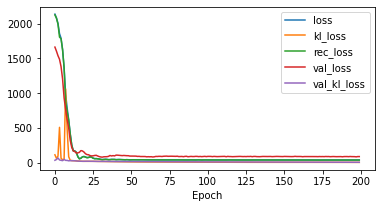

In [41]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

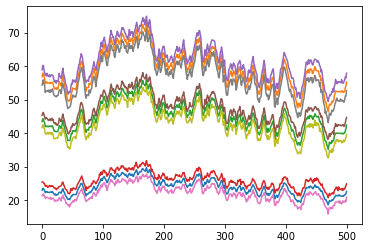

In [42]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

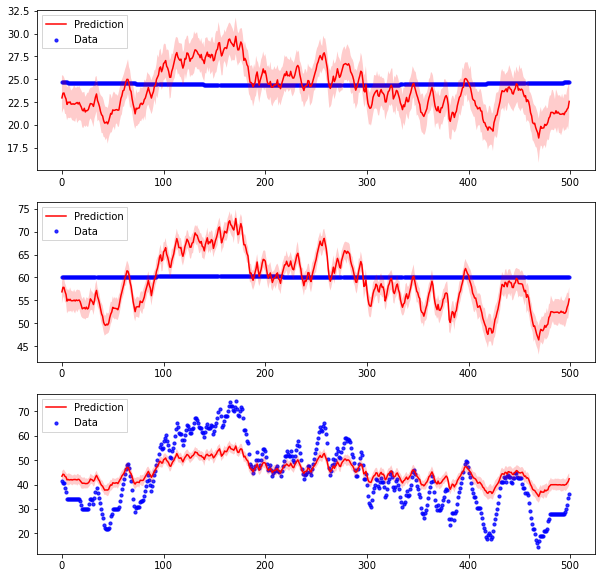

In [43]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [44]:
###################################################################################################################

In [45]:
####################################################################################################################

In [46]:
#TERAZ DKF DLA LONGITUDE DLA 3 PIERWSZYCH WORKOUTOW

## Trenowane dla 3 pierwszych treningow po longitude

In [47]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
#print(first_workout_data.shape)

In [48]:
x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
#print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
#print(x_val)

In [49]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [50]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 608.611, mse= 607.615, kld= 9.954
	val_loss= 606.587, val_mse= 606.012, val_kld= 5.748
Epoch= 2/200, loss= 602.278, mse= 601.672, kld= 6.053
	val_loss= 593.739, val_mse= 593.008, val_kld= 7.305
Epoch= 3/200, loss= 593.585, mse= 592.899, kld= 6.860
	val_loss= 581.522, val_mse= 580.547, val_kld= 9.752
Epoch= 4/200, loss= 580.562, mse= 579.585, kld= 9.771
	val_loss= 559.605, val_mse= 558.057, val_kld= 15.484
Epoch= 5/200, loss= 551.979, mse= 550.521, kld= 14.585
	val_loss= 520.882, val_mse= 518.164, val_kld= 27.177
Epoch= 6/200, loss= 512.349, mse= 509.783, kld= 25.659
	val_loss= 460.657, val_mse= 455.898, val_kld= 47.589
Epoch= 7/200, loss= 449.991, mse= 445.293, kld= 46.986
	val_loss= 383.284, val_mse= 374.130, val_kld= 91.536
Epoch= 8/200, loss= 372.516, mse= 363.153, kld= 93.625
	val_loss= 248.303, val_mse= 229.769, val_kld= 185.338
Epoch= 9/200, loss= 237.407, mse= 219.582, kld= 178.248
	val_loss= 6593.522, val_mse= 298.860, val_kld= 62946.625
Epoch= 10/200, loss=

Epoch= 79/200, loss= 12.841, mse= 12.652, kld= 1.889
	val_loss= 11.708, val_mse= 11.500, val_kld= 2.085
Epoch= 80/200, loss= 11.640, mse= 11.463, kld= 1.774
	val_loss= 10.666, val_mse= 10.482, val_kld= 1.839
Epoch= 81/200, loss= 11.037, mse= 10.863, kld= 1.743
	val_loss= 11.022, val_mse= 10.826, val_kld= 1.957
Epoch= 82/200, loss= 11.978, mse= 11.795, kld= 1.828
	val_loss= 15.178, val_mse= 14.977, val_kld= 2.013
Epoch= 83/200, loss= 11.239, mse= 11.060, kld= 1.790
	val_loss= 11.652, val_mse= 11.469, val_kld= 1.832
Epoch= 84/200, loss= 12.032, mse= 11.857, kld= 1.759
	val_loss= 12.586, val_mse= 12.393, val_kld= 1.928
Epoch= 85/200, loss= 10.936, mse= 10.767, kld= 1.688
	val_loss= 9.980, val_mse= 9.794, val_kld= 1.863
Epoch= 86/200, loss= 11.369, mse= 11.197, kld= 1.725
	val_loss= 8.310, val_mse= 8.125, val_kld= 1.856
Epoch= 87/200, loss= 11.400, mse= 11.221, kld= 1.789
	val_loss= 10.418, val_mse= 10.216, val_kld= 2.022
Epoch= 88/200, loss= 10.494, mse= 10.324, kld= 1.699
	val_loss= 9.20

Epoch= 160/200, loss= 5.400, mse= 5.266, kld= 1.338
	val_loss= 6.417, val_mse= 6.245, val_kld= 1.717
Epoch= 161/200, loss= 6.241, mse= 6.104, kld= 1.365
	val_loss= 4.969, val_mse= 4.830, val_kld= 1.390
Epoch= 162/200, loss= 6.544, mse= 6.404, kld= 1.399
	val_loss= 4.733, val_mse= 4.569, val_kld= 1.642
Epoch= 163/200, loss= 5.569, mse= 5.437, kld= 1.314
	val_loss= 6.017, val_mse= 5.849, val_kld= 1.680
Epoch= 164/200, loss= 5.629, mse= 5.493, kld= 1.362
	val_loss= 5.686, val_mse= 5.529, val_kld= 1.566
Epoch= 165/200, loss= 5.351, mse= 5.220, kld= 1.318
	val_loss= 5.584, val_mse= 5.426, val_kld= 1.575
Epoch= 166/200, loss= 5.758, mse= 5.622, kld= 1.360
	val_loss= 4.996, val_mse= 4.835, val_kld= 1.607
Epoch= 167/200, loss= 5.109, mse= 4.980, kld= 1.284
	val_loss= 5.581, val_mse= 5.429, val_kld= 1.519
Epoch= 168/200, loss= 5.454, mse= 5.321, kld= 1.329
	val_loss= 4.823, val_mse= 4.669, val_kld= 1.540
Epoch= 169/200, loss= 5.478, mse= 5.344, kld= 1.343
	val_loss= 5.520, val_mse= 5.355, val_k

<AxesSubplot:xlabel='Epoch'>

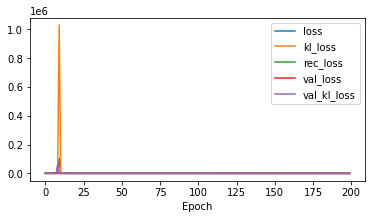

In [51]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

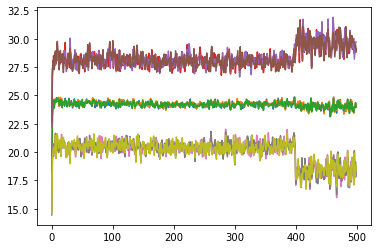

In [52]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

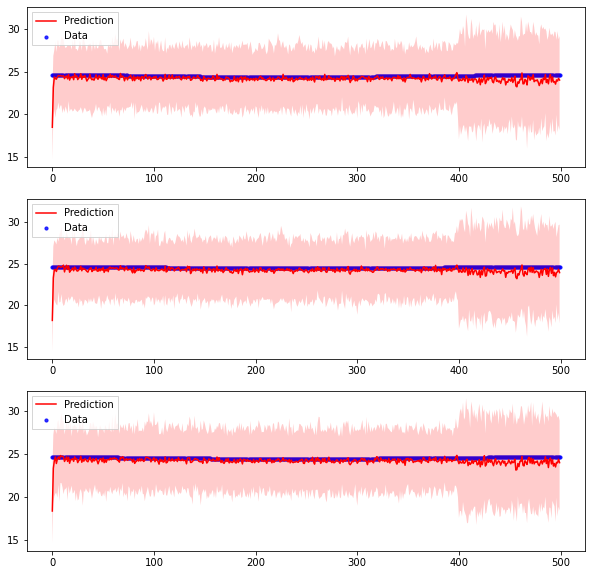

In [53]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [54]:
####################################################################################################################

In [55]:
####################################################################################################################

In [56]:
#TUTAJ DKF PO ALTITUDE DLA 5 WORKOUTOW

## Trenowane dla 5 pierwszych treningow po altitude

In [57]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

In [58]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

In [59]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [60]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2005.400, mse= 1966.889, kld= 385.108
	val_loss= 825.362, val_mse= 823.245, val_kld= 21.167
Epoch= 2/200, loss= 1930.631, mse= 1925.754, kld= 48.773
	val_loss= 811.823, val_mse= 810.357, val_kld= 14.658
Epoch= 3/200, loss= 1885.502, mse= 1882.524, kld= 29.778
	val_loss= 782.201, val_mse= 780.429, val_kld= 17.719
Epoch= 4/200, loss= 1818.449, mse= 1814.650, kld= 37.991
	val_loss= 710.922, val_mse= 708.096, val_kld= 28.259
Epoch= 5/200, loss= 1683.341, mse= 1675.457, kld= 78.840
	val_loss= 621.273, val_mse= 616.852, val_kld= 44.211
Epoch= 6/200, loss= 1449.555, mse= 1433.891, kld= 156.641
	val_loss= 436.460, val_mse= 431.211, val_kld= 52.493
Epoch= 7/200, loss= 1070.056, mse= 1051.350, kld= 187.056
	val_loss= 211.947, val_mse= 206.966, val_kld= 49.810
Epoch= 8/200, loss= 548.084, mse= 521.347, kld= 267.373
	val_loss= 67.649, val_mse= 61.811, val_kld= 58.373
Epoch= 9/200, loss= 216.366, mse= 202.954, kld= 134.127
	val_loss= 269.140, val_mse= 262.882, val_kld= 62.581
Ep

Epoch= 78/200, loss= 78.949, mse= 77.074, kld= 18.750
	val_loss= 23.772, val_mse= 21.466, val_kld= 23.063
Epoch= 79/200, loss= 79.192, mse= 77.371, kld= 18.205
	val_loss= 22.453, val_mse= 20.137, val_kld= 23.152
Epoch= 80/200, loss= 79.168, mse= 77.385, kld= 17.825
	val_loss= 23.002, val_mse= 20.686, val_kld= 23.155
Epoch= 81/200, loss= 78.794, mse= 77.043, kld= 17.505
	val_loss= 22.902, val_mse= 20.602, val_kld= 23.000
Epoch= 82/200, loss= 77.897, mse= 76.158, kld= 17.390
	val_loss= 21.911, val_mse= 19.594, val_kld= 23.175
Epoch= 83/200, loss= 78.607, mse= 76.891, kld= 17.158
	val_loss= 21.230, val_mse= 19.043, val_kld= 21.876
Epoch= 84/200, loss= 78.828, mse= 77.126, kld= 17.019
	val_loss= 24.352, val_mse= 22.164, val_kld= 21.880
Epoch= 85/200, loss= 78.294, mse= 76.613, kld= 16.809
	val_loss= 24.177, val_mse= 21.978, val_kld= 21.991
Epoch= 86/200, loss= 77.814, mse= 76.185, kld= 16.287
	val_loss= 23.110, val_mse= 20.887, val_kld= 22.228
Epoch= 87/200, loss= 77.546, mse= 75.927, kld=

Epoch= 155/200, loss= 75.729, mse= 74.724, kld= 10.051
	val_loss= 19.928, val_mse= 18.731, val_kld= 11.969
Epoch= 156/200, loss= 76.175, mse= 75.115, kld= 10.601
	val_loss= 20.615, val_mse= 19.465, val_kld= 11.496
Epoch= 157/200, loss= 76.549, mse= 75.545, kld= 10.044
	val_loss= 19.786, val_mse= 18.614, val_kld= 11.727
Epoch= 158/200, loss= 75.862, mse= 74.960, kld= 9.024
	val_loss= 20.183, val_mse= 19.066, val_kld= 11.172
Epoch= 159/200, loss= 75.560, mse= 74.604, kld= 9.559
	val_loss= 20.810, val_mse= 19.699, val_kld= 11.110
Epoch= 160/200, loss= 75.681, mse= 74.759, kld= 9.222
	val_loss= 20.001, val_mse= 18.919, val_kld= 10.817
Epoch= 161/200, loss= 75.699, mse= 74.803, kld= 8.964
	val_loss= 19.189, val_mse= 18.104, val_kld= 10.852
Epoch= 162/200, loss= 75.365, mse= 74.453, kld= 9.121
	val_loss= 20.011, val_mse= 18.933, val_kld= 10.779
Epoch= 163/200, loss= 75.564, mse= 74.663, kld= 9.011
	val_loss= 19.590, val_mse= 18.537, val_kld= 10.537
Epoch= 164/200, loss= 75.325, mse= 74.424, 

<AxesSubplot:xlabel='Epoch'>

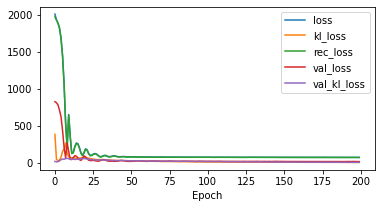

In [61]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

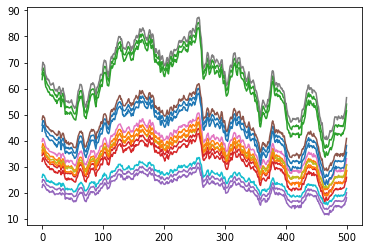

In [62]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

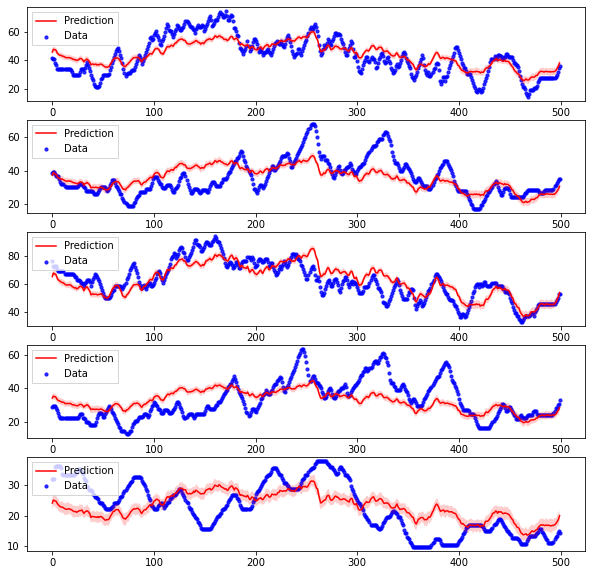

In [63]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [64]:
####################################################################################################################

In [130]:
#Preparing test synthetic datasets - each 1000 measurements

# Przygotowanie danych syntetycznych

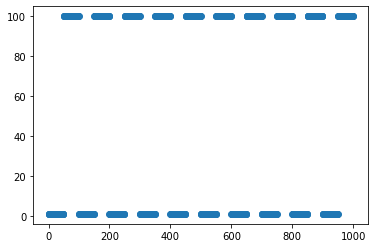

In [66]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000])
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



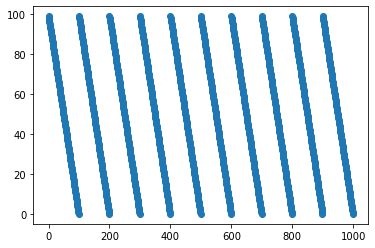

In [67]:
#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

In [68]:
#Dataset 3 - Growing from 1 to 100 then from 100 to 1

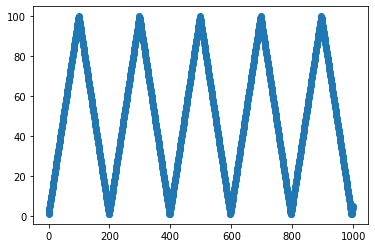

In [69]:
data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

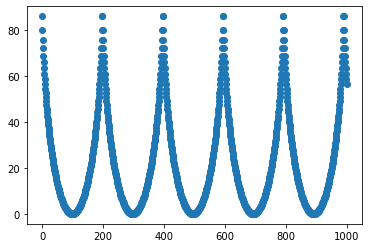

In [70]:
#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

In [71]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

In [72]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)

## Trenowanie dla danych syntetycznych

In [73]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [74]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 9781.516, mse= 3065.445, kld= 33580.348
	val_loss= 3113.489, val_mse= 3046.729, val_kld= 333.801
Epoch= 2/200, loss= 3147.812, mse= 3079.981, kld= 339.159
	val_loss= 3074.664, val_mse= 3038.626, val_kld= 180.193
Epoch= 3/200, loss= 3083.398, mse= 3046.969, kld= 182.148
	val_loss= 3013.500, val_mse= 2973.494, val_kld= 200.031
Epoch= 4/200, loss= 3017.760, mse= 2977.804, kld= 199.781
	val_loss= 2929.241, val_mse= 2881.523, val_kld= 238.591
Epoch= 5/200, loss= 2931.472, mse= 2881.846, kld= 248.131
	val_loss= 2796.022, val_mse= 2732.863, val_kld= 315.797
Epoch= 6/200, loss= 2791.465, mse= 2725.806, kld= 328.294
	val_loss= 2524.583, val_mse= 2434.120, val_kld= 452.314
Epoch= 7/200, loss= 2578.042, mse= 2480.326, kld= 488.581
	val_loss= 2222.888, val_mse= 2094.419, val_kld= 642.341
Epoch= 8/200, loss= 2252.187, mse= 2113.523, kld= 693.315
	val_loss= 752501.438, val_mse= 2134.756, val_kld= 3751833.500
Epoch= 9/200, loss= 3248.151, mse= 2166.432, kld= 5408.598
	val_loss= 18

Epoch= 75/200, loss= 331.617, mse= 325.333, kld= 31.420
	val_loss= 329.764, val_mse= 323.530, val_kld= 31.171
Epoch= 76/200, loss= 328.126, mse= 321.858, kld= 31.342
	val_loss= 320.006, val_mse= 313.769, val_kld= 31.186
Epoch= 77/200, loss= 323.934, mse= 317.681, kld= 31.263
	val_loss= 318.210, val_mse= 312.015, val_kld= 30.975
Epoch= 78/200, loss= 319.474, mse= 313.210, kld= 31.320
	val_loss= 311.381, val_mse= 305.150, val_kld= 31.151
Epoch= 79/200, loss= 317.767, mse= 311.527, kld= 31.196
	val_loss= 306.711, val_mse= 300.509, val_kld= 31.009
Epoch= 80/200, loss= 314.621, mse= 308.371, kld= 31.251
	val_loss= 306.933, val_mse= 300.743, val_kld= 30.950
Epoch= 81/200, loss= 310.337, mse= 304.093, kld= 31.217
	val_loss= 304.414, val_mse= 298.241, val_kld= 30.864
Epoch= 82/200, loss= 307.639, mse= 301.416, kld= 31.117
	val_loss= 296.834, val_mse= 290.685, val_kld= 30.749
Epoch= 83/200, loss= 303.832, mse= 297.637, kld= 30.975
	val_loss= 296.268, val_mse= 290.151, val_kld= 30.585
Epoch= 84/

Epoch= 151/200, loss= 46.028, mse= 40.271, kld= 28.786
	val_loss= 46.906, val_mse= 41.226, val_kld= 28.398
Epoch= 152/200, loss= 46.526, mse= 40.789, kld= 28.685
	val_loss= 49.276, val_mse= 43.602, val_kld= 28.370
Epoch= 153/200, loss= 46.500, mse= 40.807, kld= 28.467
	val_loss= 46.734, val_mse= 41.101, val_kld= 28.166
Epoch= 154/200, loss= 44.734, mse= 39.051, kld= 28.415
	val_loss= 46.185, val_mse= 40.576, val_kld= 28.043
Epoch= 155/200, loss= 44.408, mse= 38.752, kld= 28.275
	val_loss= 46.844, val_mse= 41.270, val_kld= 27.872
Epoch= 156/200, loss= 44.737, mse= 39.103, kld= 28.170
	val_loss= 46.101, val_mse= 40.545, val_kld= 27.777
Epoch= 157/200, loss= 45.039, mse= 39.422, kld= 28.088
	val_loss= 46.972, val_mse= 41.455, val_kld= 27.581
Epoch= 158/200, loss= 45.775, mse= 40.185, kld= 27.950
	val_loss= 46.590, val_mse= 41.064, val_kld= 27.627
Epoch= 159/200, loss= 44.395, mse= 38.847, kld= 27.737
	val_loss= 45.260, val_mse= 39.770, val_kld= 27.453
Epoch= 160/200, loss= 44.407, mse= 38

<AxesSubplot:xlabel='Epoch'>

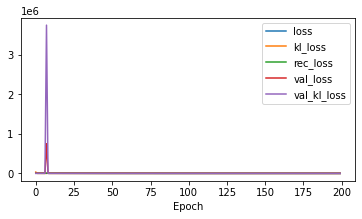

In [75]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

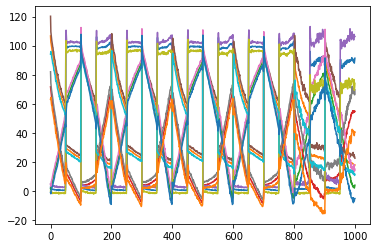

In [76]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

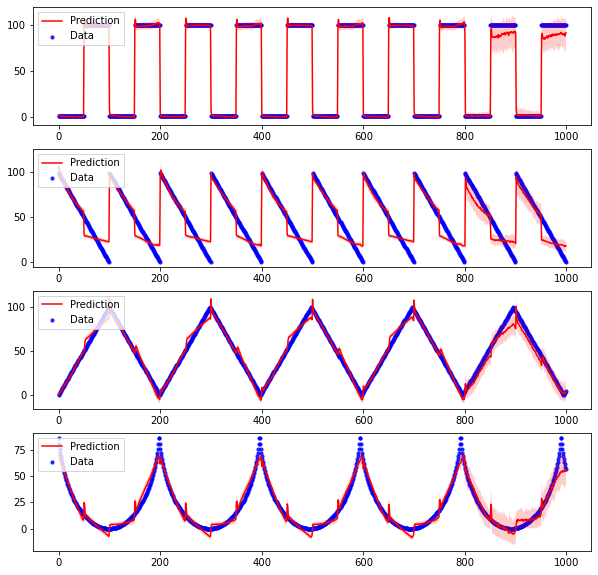

In [77]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [78]:
#################################################################################

# Przesuniecie i normalizacja danych

## Trenowanie dla pierwszych 5 treningow po przesunieciu w plaszczyznie longitude x latitude

In [79]:
#5 Workoutow, gdzie zbijamy longitude i latitude w przesuniecie



def translation(i):
    lon = np.asarray(data_endo[i]['longitude'])
    lat = np.asarray(data_endo[i]['latitude'])
    tra = np.sqrt(np.power(lon, 2) + np.power(lat,2))
    return tra

data = np.vstack( [translation(i) for i in range(5)]).T
#print(data.shape)

In [80]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [85]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [86]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 4216.039, mse= 4191.806, kld= 121.161
	val_loss= 4088.448, val_mse= 4065.533, val_kld= 114.571
Epoch= 2/200, loss= 4086.384, mse= 4063.202, kld= 115.910
	val_loss= 3810.938, val_mse= 3772.804, val_kld= 190.670
Epoch= 3/200, loss= 3791.244, mse= 3753.598, kld= 188.231
	val_loss= 3238.750, val_mse= 3204.529, val_kld= 171.102
Epoch= 4/200, loss= 3220.132, mse= 3186.787, kld= 166.726
	val_loss= 2226.942, val_mse= 2200.832, val_kld= 130.553
Epoch= 5/200, loss= 2204.635, mse= 2180.047, kld= 122.943
	val_loss= 890.374, val_mse= 855.860, val_kld= 172.568
Epoch= 6/200, loss= 841.280, mse= 812.472, kld= 144.041
	val_loss= 1124.537, val_mse= 1077.920, val_kld= 233.089
Epoch= 7/200, loss= 1148.478, mse= 1111.739, kld= 183.693
	val_loss= 652.439, val_mse= 619.773, val_kld= 163.332
Epoch= 8/200, loss= 682.817, mse= 657.085, kld= 128.657
	val_loss= 157.692, val_mse= 137.954, val_kld= 98.688
Epoch= 9/200, loss= 125.743, mse= 110.380, kld= 76.813
	val_loss= 219.133, val_mse= 201.652

Epoch= 79/200, loss= 4.239, mse= 2.476, kld= 8.813
	val_loss= 5.929, val_mse= 3.707, val_kld= 11.109
Epoch= 80/200, loss= 3.961, mse= 2.241, kld= 8.601
	val_loss= 5.368, val_mse= 3.131, val_kld= 11.183
Epoch= 81/200, loss= 3.897, mse= 2.161, kld= 8.679
	val_loss= 5.111, val_mse= 2.919, val_kld= 10.959
Epoch= 82/200, loss= 4.186, mse= 2.458, kld= 8.640
	val_loss= 4.992, val_mse= 2.916, val_kld= 10.382
Epoch= 83/200, loss= 4.011, mse= 2.345, kld= 8.330
	val_loss= 5.010, val_mse= 2.865, val_kld= 10.724
Epoch= 84/200, loss= 3.829, mse= 2.161, kld= 8.339
	val_loss= 5.724, val_mse= 3.521, val_kld= 11.012
Epoch= 85/200, loss= 3.714, mse= 2.077, kld= 8.182
	val_loss= 5.059, val_mse= 2.847, val_kld= 11.060
Epoch= 86/200, loss= 3.760, mse= 2.107, kld= 8.263
	val_loss= 4.892, val_mse= 2.751, val_kld= 10.708
Epoch= 87/200, loss= 3.801, mse= 2.182, kld= 8.094
	val_loss= 5.046, val_mse= 2.996, val_kld= 10.249
Epoch= 88/200, loss= 3.664, mse= 2.072, kld= 7.960
	val_loss= 4.823, val_mse= 2.767, val_kl

Epoch= 161/200, loss= 2.342, mse= 1.202, kld= 5.701
	val_loss= 2.836, val_mse= 1.348, val_kld= 7.442
Epoch= 162/200, loss= 2.389, mse= 1.260, kld= 5.648
	val_loss= 2.989, val_mse= 1.526, val_kld= 7.313
Epoch= 163/200, loss= 2.373, mse= 1.265, kld= 5.541
	val_loss= 2.715, val_mse= 1.242, val_kld= 7.366
Epoch= 164/200, loss= 2.475, mse= 1.340, kld= 5.675
	val_loss= 2.684, val_mse= 1.188, val_kld= 7.482
Epoch= 165/200, loss= 2.476, mse= 1.361, kld= 5.576
	val_loss= 2.852, val_mse= 1.381, val_kld= 7.355
Epoch= 166/200, loss= 2.474, mse= 1.332, kld= 5.710
	val_loss= 2.820, val_mse= 1.222, val_kld= 7.989
Epoch= 167/200, loss= 2.384, mse= 1.214, kld= 5.846
	val_loss= 2.844, val_mse= 1.384, val_kld= 7.304
Epoch= 168/200, loss= 2.430, mse= 1.310, kld= 5.598
	val_loss= 2.768, val_mse= 1.236, val_kld= 7.655
Epoch= 169/200, loss= 2.395, mse= 1.262, kld= 5.663
	val_loss= 2.693, val_mse= 1.249, val_kld= 7.219
Epoch= 170/200, loss= 2.372, mse= 1.209, kld= 5.814
	val_loss= 2.764, val_mse= 1.274, val_k

<AxesSubplot:xlabel='Epoch'>

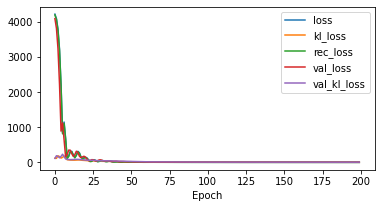

In [87]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

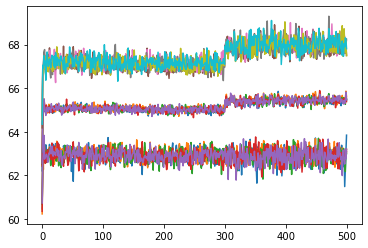

In [88]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

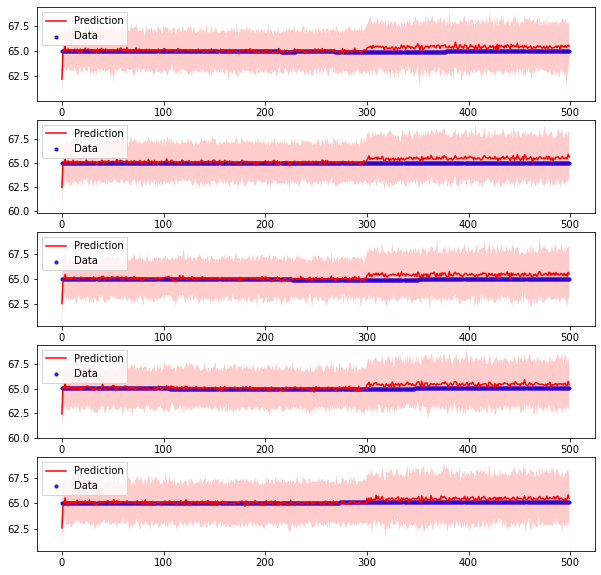

In [89]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [ ]:
##########################################################################################################

## Trenowane dla znormalizowanych latitude i longitude

In [90]:
#Normalizacja dla 2D - latitude i longitude


def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
#norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat]).T
#print(data.shape)


In [91]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [92]:
dkf = DKF(input_dim=2, z_dim=10, rnn_dim=10, trans_dim=10, emission_dim=10)

In [93]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 3807.126, mse= 2935.846, kld= 8712.804
	val_loss= 2409.694, val_mse= 2399.504, val_kld= 101.893
Epoch= 2/200, loss= 2948.892, mse= 2944.320, kld= 45.729
	val_loss= 2400.162, val_mse= 2395.637, val_kld= 45.247
Epoch= 3/200, loss= 2930.590, mse= 2926.911, kld= 36.790
	val_loss= 2373.984, val_mse= 2370.500, val_kld= 34.835
Epoch= 4/200, loss= 2926.578, mse= 2922.917, kld= 36.612
	val_loss= 2388.612, val_mse= 2385.838, val_kld= 27.743
Epoch= 5/200, loss= 2898.389, mse= 2894.486, kld= 39.031
	val_loss= 2348.069, val_mse= 2345.375, val_kld= 26.932
Epoch= 6/200, loss= 2883.536, mse= 2879.411, kld= 41.256
	val_loss= 2338.518, val_mse= 2335.853, val_kld= 26.648
Epoch= 7/200, loss= 2853.299, mse= 2848.437, kld= 48.618
	val_loss= 2295.796, val_mse= 2292.956, val_kld= 28.407
Epoch= 8/200, loss= 2809.452, mse= 2803.538, kld= 59.139
	val_loss= 2259.435, val_mse= 2256.462, val_kld= 29.737
Epoch= 9/200, loss= 2760.859, mse= 2753.680, kld= 71.791
	val_loss= 2216.229, val_mse= 2212.8

Epoch= 75/200, loss= 204.540, mse= 203.513, kld= 10.278
	val_loss= 370.232, val_mse= 368.512, val_kld= 17.203
Epoch= 76/200, loss= 182.650, mse= 181.614, kld= 10.359
	val_loss= 318.354, val_mse= 316.614, val_kld= 17.400
Epoch= 77/200, loss= 165.792, mse= 164.755, kld= 10.368
	val_loss= 282.536, val_mse= 280.768, val_kld= 17.682
Epoch= 78/200, loss= 150.682, mse= 149.651, kld= 10.309
	val_loss= 250.445, val_mse= 248.651, val_kld= 17.934
Epoch= 79/200, loss= 131.333, mse= 130.295, kld= 10.379
	val_loss= 214.562, val_mse= 212.814, val_kld= 17.480
Epoch= 80/200, loss= 121.832, mse= 120.798, kld= 10.338
	val_loss= 196.608, val_mse= 194.815, val_kld= 17.923
Epoch= 81/200, loss= 100.860, mse= 99.817, kld= 10.423
	val_loss= 164.336, val_mse= 162.591, val_kld= 17.449
Epoch= 82/200, loss= 94.502, mse= 93.450, kld= 10.525
	val_loss= 152.995, val_mse= 151.182, val_kld= 18.131
Epoch= 83/200, loss= 79.011, mse= 77.957, kld= 10.539
	val_loss= 137.328, val_mse= 135.481, val_kld= 18.477
Epoch= 84/200, 

Epoch= 152/200, loss= 9.392, mse= 8.331, kld= 10.611
	val_loss= 7.523, val_mse= 5.823, val_kld= 17.000
Epoch= 153/200, loss= 8.512, mse= 7.451, kld= 10.604
	val_loss= 8.665, val_mse= 6.990, val_kld= 16.749
Epoch= 154/200, loss= 9.669, mse= 8.613, kld= 10.559
	val_loss= 8.059, val_mse= 6.353, val_kld= 17.061
Epoch= 155/200, loss= 9.916, mse= 8.744, kld= 11.720
	val_loss= 8.772, val_mse= 7.070, val_kld= 17.023
Epoch= 156/200, loss= 9.127, mse= 8.065, kld= 10.612
	val_loss= 7.987, val_mse= 6.296, val_kld= 16.912
Epoch= 157/200, loss= 9.596, mse= 8.537, kld= 10.591
	val_loss= 8.352, val_mse= 6.655, val_kld= 16.976
Epoch= 158/200, loss= 9.364, mse= 8.301, kld= 10.630
	val_loss= 9.121, val_mse= 7.381, val_kld= 17.404
Epoch= 159/200, loss= 8.767, mse= 7.717, kld= 10.495
	val_loss= 8.568, val_mse= 6.892, val_kld= 16.765
Epoch= 160/200, loss= 9.487, mse= 8.417, kld= 10.707
	val_loss= 9.481, val_mse= 7.794, val_kld= 16.869
Epoch= 161/200, loss= 8.504, mse= 7.459, kld= 10.448
	val_loss= 8.019, va

<AxesSubplot:xlabel='Epoch'>

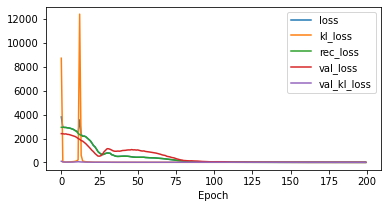

In [94]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

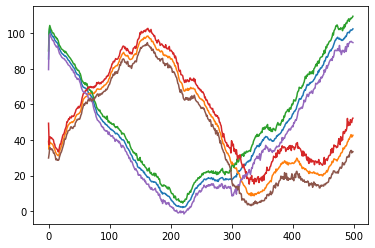

In [95]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

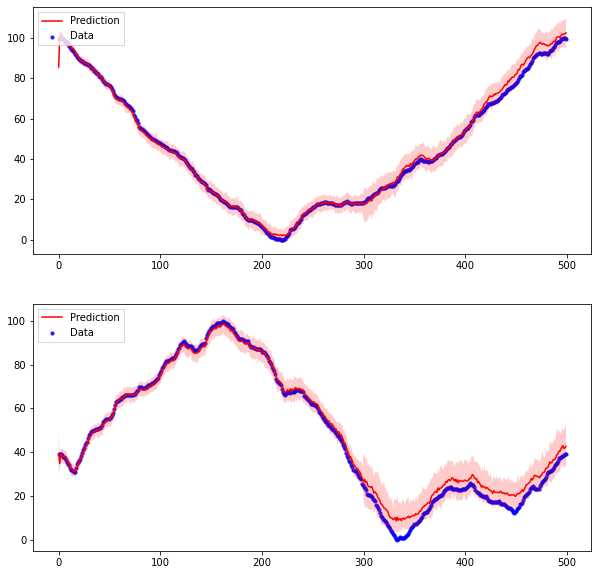

In [96]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [97]:
#Normalizacja dla 3D - latitude, longitude i altitude

## Trenowanie dla znormalizowanych danych latitude, longitude, altitude

In [105]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat, norm_alt]).T
#print(data.shape)


In [112]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [113]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [114]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 4221.733, mse= 3018.567, kld= 8021.112
	val_loss= 2020.732, val_mse= 2006.235, val_kld= 96.650
Epoch= 2/200, loss= 3014.642, mse= 3002.156, kld= 83.235
	val_loss= 1990.798, val_mse= 1981.331, val_kld= 63.111
Epoch= 3/200, loss= 2992.583, mse= 2986.338, kld= 41.633
	val_loss= 1969.912, val_mse= 1962.406, val_kld= 50.037
Epoch= 4/200, loss= 2989.960, mse= 2985.093, kld= 32.449
	val_loss= 1966.978, val_mse= 1960.112, val_kld= 45.770
Epoch= 5/200, loss= 2951.449, mse= 2947.028, kld= 29.470
	val_loss= 1919.699, val_mse= 1913.929, val_kld= 38.466
Epoch= 6/200, loss= 2926.813, mse= 2922.271, kld= 30.279
	val_loss= 1872.975, val_mse= 1867.310, val_kld= 37.763
Epoch= 7/200, loss= 2871.569, mse= 2866.552, kld= 33.446
	val_loss= 1825.710, val_mse= 1820.282, val_kld= 36.189
Epoch= 8/200, loss= 2802.319, mse= 2796.976, kld= 35.619
	val_loss= 1743.551, val_mse= 1738.099, val_kld= 36.345
Epoch= 9/200, loss= 2692.185, mse= 2686.415, kld= 38.465
	val_loss= 1641.502, val_mse= 1636.97

Epoch= 75/200, loss= 123.517, mse= 121.280, kld= 14.915
	val_loss= 171.863, val_mse= 169.242, val_kld= 17.475
Epoch= 76/200, loss= 117.094, mse= 114.891, kld= 14.688
	val_loss= 162.471, val_mse= 159.902, val_kld= 17.128
Epoch= 77/200, loss= 110.911, mse= 108.741, kld= 14.467
	val_loss= 160.149, val_mse= 157.566, val_kld= 17.221
Epoch= 78/200, loss= 104.048, mse= 101.903, kld= 14.299
	val_loss= 169.963, val_mse= 167.430, val_kld= 16.887
Epoch= 79/200, loss= 101.542, mse= 99.417, kld= 14.168
	val_loss= 171.630, val_mse= 169.113, val_kld= 16.780
Epoch= 80/200, loss= 99.180, mse= 97.055, kld= 14.165
	val_loss= 162.902, val_mse= 160.392, val_kld= 16.730
Epoch= 81/200, loss= 97.805, mse= 95.702, kld= 14.017
	val_loss= 161.341, val_mse= 158.889, val_kld= 16.344
Epoch= 82/200, loss= 97.124, mse= 95.037, kld= 13.916
	val_loss= 156.191, val_mse= 153.763, val_kld= 16.188
Epoch= 83/200, loss= 96.924, mse= 94.860, kld= 13.761
	val_loss= 152.549, val_mse= 150.133, val_kld= 16.103
Epoch= 84/200, loss

Epoch= 151/200, loss= 74.188, mse= 72.701, kld= 9.913
	val_loss= 100.155, val_mse= 98.366, val_kld= 11.925
Epoch= 152/200, loss= 75.578, mse= 74.097, kld= 9.875
	val_loss= 103.966, val_mse= 102.247, val_kld= 11.460
Epoch= 153/200, loss= 76.061, mse= 74.591, kld= 9.799
	val_loss= 102.834, val_mse= 101.091, val_kld= 11.624
Epoch= 154/200, loss= 75.409, mse= 73.908, kld= 10.002
	val_loss= 98.665, val_mse= 96.942, val_kld= 11.490
Epoch= 155/200, loss= 76.278, mse= 74.796, kld= 9.877
	val_loss= 98.572, val_mse= 96.895, val_kld= 11.178
Epoch= 156/200, loss= 75.091, mse= 73.622, kld= 9.793
	val_loss= 102.468, val_mse= 100.730, val_kld= 11.588
Epoch= 157/200, loss= 74.602, mse= 73.153, kld= 9.664
	val_loss= 101.684, val_mse= 100.007, val_kld= 11.182
Epoch= 158/200, loss= 74.528, mse= 73.058, kld= 9.802
	val_loss= 100.117, val_mse= 98.478, val_kld= 10.926
Epoch= 159/200, loss= 74.323, mse= 72.870, kld= 9.689
	val_loss= 98.467, val_mse= 96.771, val_kld= 11.309
Epoch= 160/200, loss= 73.446, mse= 

<AxesSubplot:xlabel='Epoch'>

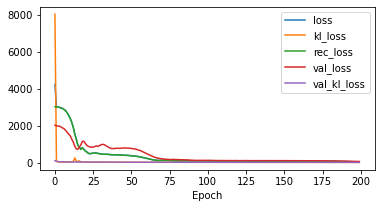

In [115]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

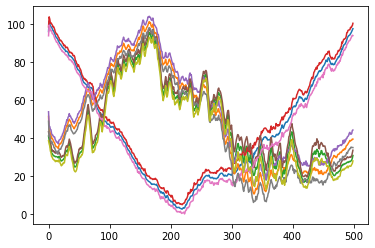

In [116]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

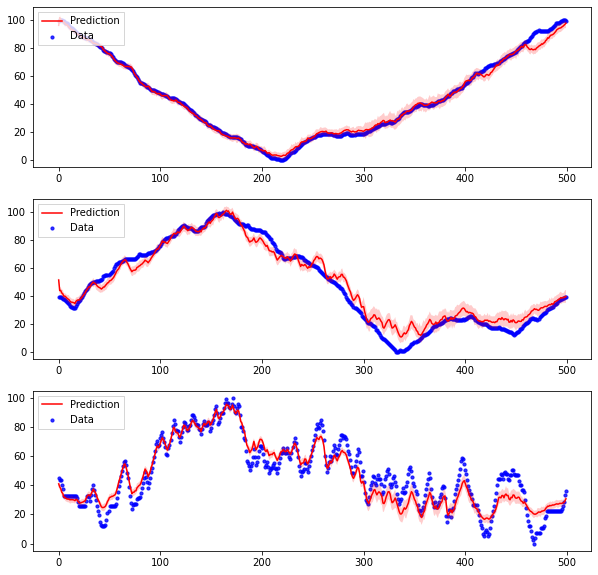

In [117]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [ ]:
############################################################################################################

In [ ]:
#5 Workoutow ze znormalizowanym altitude

## 5 treningow z znormalizowanych altitude

In [118]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

data = np.vstack([NormalizeData(np.asarray(data_endo[i]['altitude'])) for i in range(5)]).T
#print(data.shape)


In [119]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [124]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [125]:
history = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 2976.399, mse= 2937.448, kld= 259.675
	val_loss= 792.484, val_mse= 790.710, val_kld= 11.825
Epoch= 2/200, loss= 2915.403, mse= 2908.163, kld= 48.270
	val_loss= 768.934, val_mse= 767.336, val_kld= 10.651
Epoch= 3/200, loss= 2859.369, mse= 2853.604, kld= 38.435
	val_loss= 745.941, val_mse= 743.911, val_kld= 13.531
Epoch= 4/200, loss= 2752.967, mse= 2744.765, kld= 54.675
	val_loss= 677.029, val_mse= 674.284, val_kld= 18.305
Epoch= 5/200, loss= 2543.289, mse= 2531.938, kld= 75.668
	val_loss= 562.338, val_mse= 557.872, val_kld= 29.775
Epoch= 6/200, loss= 2176.268, mse= 2137.145, kld= 260.823
	val_loss= 403.796, val_mse= 395.637, val_kld= 54.388
Epoch= 7/200, loss= 4852.684, mse= 1578.551, kld= 21827.553
	val_loss= 338.001, val_mse= 332.757, val_kld= 34.965
Epoch= 8/200, loss= 1444.489, mse= 1428.133, kld= 109.038
	val_loss= 298.545, val_mse= 294.196, val_kld= 28.996
Epoch= 9/200, loss= 1259.006, mse= 1246.854, kld= 81.016
	val_loss= 252.960, val_mse= 248.900, val_kld= 27

Epoch= 76/200, loss= 362.002, mse= 360.014, kld= 13.255
	val_loss= 135.351, val_mse= 133.970, val_kld= 9.207
Epoch= 77/200, loss= 359.707, mse= 357.749, kld= 13.055
	val_loss= 129.117, val_mse= 127.764, val_kld= 9.019
Epoch= 78/200, loss= 360.481, mse= 358.529, kld= 13.013
	val_loss= 131.170, val_mse= 129.888, val_kld= 8.549
Epoch= 79/200, loss= 360.630, mse= 358.752, kld= 12.523
	val_loss= 134.540, val_mse= 133.152, val_kld= 9.251
Epoch= 80/200, loss= 360.055, mse= 358.131, kld= 12.828
	val_loss= 130.306, val_mse= 129.018, val_kld= 8.589
Epoch= 81/200, loss= 360.475, mse= 358.599, kld= 12.511
	val_loss= 136.522, val_mse= 135.255, val_kld= 8.445
Epoch= 82/200, loss= 359.160, mse= 357.292, kld= 12.456
	val_loss= 130.395, val_mse= 129.117, val_kld= 8.515
Epoch= 83/200, loss= 361.141, mse= 359.292, kld= 12.331
	val_loss= 129.775, val_mse= 128.525, val_kld= 8.333
Epoch= 84/200, loss= 359.625, mse= 357.827, kld= 11.984
	val_loss= 127.228, val_mse= 125.984, val_kld= 8.294
Epoch= 85/200, loss

Epoch= 151/200, loss= 232.170, mse= 230.507, kld= 11.088
	val_loss= 106.919, val_mse= 105.749, val_kld= 7.801
Epoch= 152/200, loss= 226.951, mse= 225.228, kld= 11.486
	val_loss= 109.260, val_mse= 108.083, val_kld= 7.850
Epoch= 153/200, loss= 220.912, mse= 219.215, kld= 11.313
	val_loss= 111.217, val_mse= 110.091, val_kld= 7.511
Epoch= 154/200, loss= 215.169, mse= 213.443, kld= 11.503
	val_loss= 102.933, val_mse= 101.792, val_kld= 7.611
Epoch= 155/200, loss= 209.604, mse= 207.893, kld= 11.408
	val_loss= 106.285, val_mse= 105.158, val_kld= 7.516
Epoch= 156/200, loss= 204.654, mse= 202.815, kld= 12.258
	val_loss= 104.061, val_mse= 102.863, val_kld= 7.987
Epoch= 157/200, loss= 202.406, mse= 200.608, kld= 11.990
	val_loss= 104.145, val_mse= 102.957, val_kld= 7.922
Epoch= 158/200, loss= 195.969, mse= 194.223, kld= 11.637
	val_loss= 102.470, val_mse= 101.248, val_kld= 8.149
Epoch= 159/200, loss= 193.337, mse= 191.540, kld= 11.977
	val_loss= 101.938, val_mse= 100.747, val_kld= 7.941
Epoch= 160

<AxesSubplot:xlabel='Epoch'>

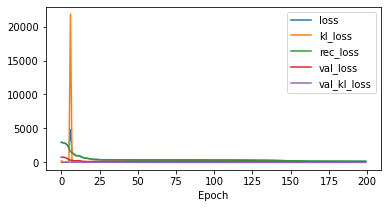

In [127]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

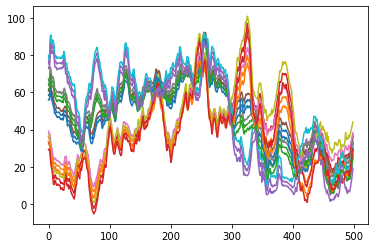

In [128]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

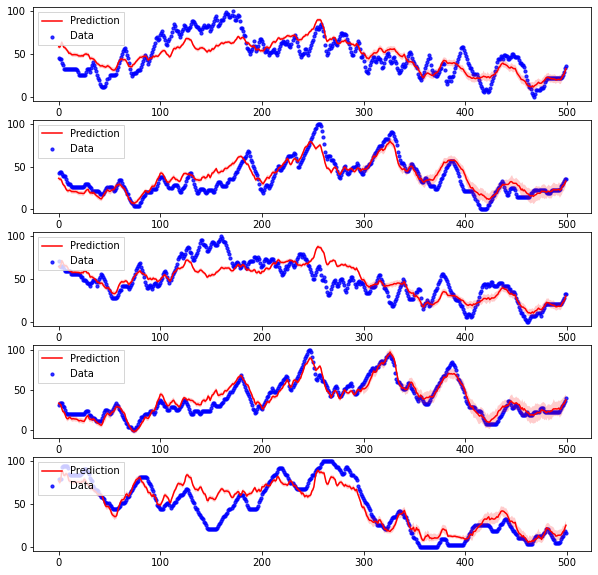

In [129]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()